In [1]:
'''
Author        : Aditya Jain
Date Started  : 14th June, 2021
About         : This script generates Grad-Class Activation Maps (GradCAM) and bbox for one image
'''
import sys, os
sys.path.append('/home/mila/a/aditya.jain/mothAI/deeplearning')

import numpy as np
import tensorflow as tf
from tensorflow import keras
import json
from torchvision import transforms
import torch
from models.resnet50 import Resnet50
from torchsummary import summary
import torchvision.models as models
from torch import nn
from PIL import Image
import cv2
from scipy import ndimage

# Display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

image_path   = 'test2.jpg'
image_resize = 224
config_file  = '/home/mila/a/aditya.jain/mothAI/deeplearning/config/01-config.json' 
PATH         = '/home/mila/a/aditya.jain/logs/v01_mothmodel_2021-06-08-04-53.pt'
label_file   = '/home/mila/a/aditya.jain/mothAI/deeplearning/data/numeric_labels.json'

In [2]:
# model loading
f           = open(config_file)
config_data = json.load(f)

device      = "cuda" if torch.cuda.is_available() else "cpu"
model       = Resnet50(config_data).to(device)

checkpoint  = torch.load(PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# print(model)
# print(summary(model, (3,image_resize,image_resize)))  # keras-type model summary

# adding hook on the last convolution layer
last_conv_output = None

def hook(module, input, output):
    global last_conv_output
    last_conv_output = output    

model.backbone[7][2].relu.register_forward_hook(hook)

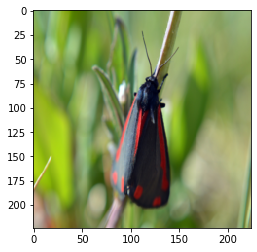

In [3]:
# image loading and processing
image     = Image.open(image_path)

transform = transforms.Compose([
                        transforms.Resize((image_resize, image_resize)),              # resize the image to 224x224 
                        transforms.ToTensor()])
image     = transform(image)
image     = torch.unsqueeze(image, 0).to(device)

test_im = np.array(image.squeeze())
test_im = np.moveaxis(test_im, 0, -1)
test_im.shape

plt.imshow(test_im)

In [4]:
model.eval()
out = model(image)
_, predict_indx = torch.topk(out, 1)

f            = open(label_file)
label_info   = json.load(f)
species_list = label_info['species_list']

print('The predicted species is : ', species_list[predict_indx])

The predicted species is :  Tyria jacobaeae


In [5]:
last_conv_output = last_conv_output[0]
print('Last convolution shape: ', last_conv_output.shape)
conv_shape = last_conv_output.shape

for name, param in model.named_parameters():
    if name == 'classifier.weight':
        classifier_weights = param 
        break

print('Classifier weights shape: ', classifier_weights.shape)
topclass_weights = classifier_weights[predict_indx,:][0][0]
print('Weights count: ', topclass_weights.shape)

Last convolution shape:  torch.Size([2048, 7, 7])
Classifier weights shape:  torch.Size([768, 2048])
Weights count:  torch.Size([2048])


In [6]:
cam = np.zeros((conv_shape[1], conv_shape[1]))

for i in range(conv_shape[1]):
    for j in range(conv_shape[1]):
        for k in range(conv_shape[0]):
            cam[i,j] += topclass_weights[k]*last_conv_output[k,i,j]

CAM after normalization:  [[0.01612072 0.05043937 0.09939748 0.14009659 0.12621257 0.07678667
  0.03117372]
 [0.03835905 0.19365531 0.3569606  0.34203028 0.37361092 0.29955528
  0.21176134]
 [0.06734682 0.38129281 0.51794215 0.53261398 0.63905786 0.55999743
  0.45779423]
 [0.07601736 0.42609525 0.61499184 0.69342497 0.83582602 0.68713408
  0.58953344]
 [0.09133919 0.47485101 0.6968818  0.85412062 0.96809569 0.76035658
  0.61306697]
 [0.09043111 0.47004138 0.82140286 0.90383707 1.         0.77382135
  0.51507968]
 [0.03962212 0.27110649 0.60487578 0.78224635 0.8718034  0.62990242
  0.33290169]]


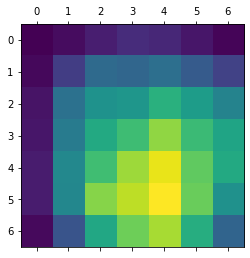

In [7]:
# print('CAM: ', cam)
cam = np.maximum(cam, 0)/np.amax(cam)
plt.matshow(cam)
print('CAM after normalization: ', cam)

True

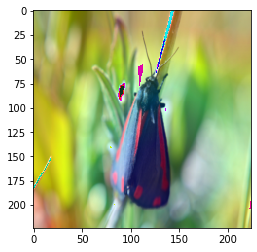

In [8]:
heatmap          = cv2.resize(cam, (image_resize, image_resize))
heatmap          = np.uint8(255 * heatmap)
heatmap          = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

orig_im          = np.uint8(255 * test_im)

superimposed_img = heatmap*0.2 + orig_im

plt.imshow(np.uint8(superimposed_img))
cv2.imwrite('map.jpg', superimposed_img)

#### Thresholding

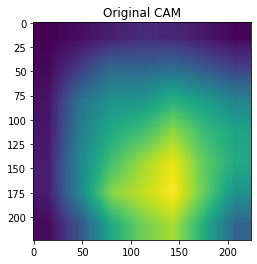

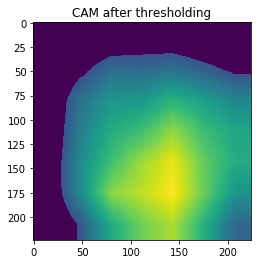

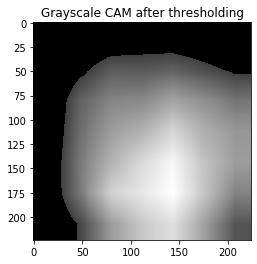

In [9]:
heatmap           = cv2.resize(cam, (image_resize, image_resize))
heatmap           = np.uint8(255 * heatmap)
plt.figure()
plt.title('Original CAM')
plt.imshow(heatmap)

# only take those pixels with atleast 30% value of max
threshold_val     = 0.25*np.amax(heatmap)
threshold_heatmap = (heatmap > threshold_val) * heatmap
plt.figure()
plt.title('CAM after thresholding')
plt.imshow(threshold_heatmap)

plt.figure()
plt.title('Grayscale CAM after thresholding')
plt.imshow(threshold_heatmap, cmap=plt.cm.gray)

#### Getting the cropped image 
required only till here for actual process

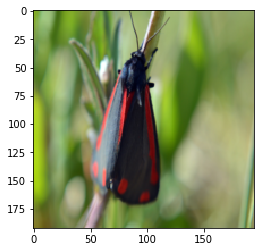

In [10]:
labels, nb  = ndimage.label(threshold_heatmap)
crop_loc    = ndimage.find_objects(labels==1)
cropped_im  = test_im[crop_loc[0]]

plt.imshow(cropped_im)

#### Bounding box annotation for visualization

In [11]:
y_start = crop_loc[0][0].start
y_stop  = crop_loc[0][0].stop

x_start = crop_loc[0][1].start
x_stop  = crop_loc[0][1].stop

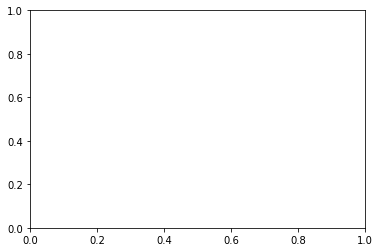

In [19]:
img_plot = plt.imshow(test_im)
# plt.figure()

ax   = plt.gca()
rect = patches.Rectangle((x_start,y_start),
                 x_stop-x_start,
                 y_stop-y_start,
                 linewidth=3,
                 edgecolor='red',
                 fill = False)

ax.add_patch(rect)
# plt.show()
plt.savefig('bbox.png')